In [1]:
import os
import uuid
from tqdm import tqdm
import itertools

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import ants


from tools.config import Config, read_conf

In [2]:
class MRTDataset(Dataset):
    def __init__(self, config, health_flg, transform=None):
        self.config = config
        self.transform = transform
        self.person_dict = {}
        self.person_list = []
        self.health_flg = health_flg
        self._init_dataset()

    def _init_dataset(self):
        max_batch = self.config.train.max_batch if self.health_flg else self.config.test.max_batch
        for address, dirs, files in os.walk(os.path.join(
                self.config.train_path if self.health_flg else self.config.test_path,
                self.config.train_local if self.health_flg else self.config.test_local
        )):
            for file in files:
                if file.endswith(('.nii.gz', '_brain.mha')):
                    person = Person(os.path.join(address, file))
                    if not self.health_flg:
                        person.set_tumor()
                    if (not self.config.slice) or (
                            isinstance(self.config.slice, int) and self.config.slice >= person.num) or (
                            isinstance(self.config.slice, list) and (len(self.config.slice) == 2) and (
                            self.config.slice[0] <= person.num < self.config.slice[1])):
                        self.person_dict[person.uuid] = person
                        self.person_list.append(person)
                if len(self.person_list) >= max_batch:
                    break
            if len(self.person_list) >= max_batch:
                break

    def __str__(self):
        ans = ''
        for person in list(self.person_dict.values()):
            ans += f'{person.__repr__()}\n'
        return ans[:-1] if ans else ''

    def __repr__(self):
        ans = ''
        for person in list(self.person_dict.values()):
            ans += f'{person}\n'
        return ans[:-1] if ans else ''

    def __len__(self):
        return len(self.person_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.get_person(idx)(self.transform)

    def dataloader(self, shuffle=True):
        return DataLoader(self,
                          batch_size=self.config.train.batch_size if self.health_flg else self.config.test.batch_size,
                          shuffle=shuffle)

    def get_img_shape(self):
        return list(self.get_random()(self.transform).shape) if len(self.person_list) != 0 else 0

    def get_random(self):
        return np.random.choice(self.person_list, 1)[0]

    def get_person(self, idx):
        if isinstance(idx, str):
            return self.person_dict[idx]
        elif isinstance(idx, int):
            return self.person_list[idx]
        else:
            raise TypeError(f'Неверный тип. Хотел: int или str, а получил {idx.__type__}')


class Person:
    def __init__(self, path):
        self.uuid = str(uuid.uuid4())
        self.path = path
        self.tumor = None
        self.name = path.split('/')[-1].split('.')[0]
        if self.path.endswith('.nii.gz'):
            self.num = int(self.name.split('_')[-1])
        if self.path.endswith('.mha'):
            self.num = int(self.name.split('_')[0][3:])

    def __str__(self):
        return f"{self.uuid}: {self.path}"

    def __repr__(self):
        return f"{self.uuid[:-6]}: {self.name}"

    def get_tumor(self, transform=None):
        if self.tumor:
            img = ants.image_read(self.tumor)
            return transform(img) if transform else img
        else:
            return None

    def set_tumor(self):
        self.tumor = f'{self.path[:-10]}_tumor.mha'

    def plot(self):
        self.get_brain().plot()

    def get_brain(self, np_flg=False):
        img = ants.image_read(self.path)
        return img.numpy() if np_flg else img

    def __call__(self, transform=None):
        return transform(self.get_brain()) if transform else self.get_brain(np_flg=True).astype(np.float32)

In [3]:
def generator(config, train_flg):
    trf = []
    if config.transforms.norm:
        trf.append(ants.iMath_normalize)
    if config.transforms.resize:
        def resize(obj, img_size=config.transforms.img_size):
            return obj.resample_image((img_size, img_size, obj.shape[2]), 1, 0)
        trf.append(resize)
    trf.append(lambda x: np.flip(x.numpy(), 1).astype(np.float32) if train_flg else x.numpy().astype(np.float32))
    if config.transforms.to_tensor:
        trf.append(transforms.ToTensor())

    dataset = MRTDataset(config=config, health_flg=train_flg, transform=transforms.Compose(trf))

    return dataset

In [4]:
class AAE():
    def __init__(self, config, train_flg=True):
        self.config = config.train if train_flg else config.test
        self.output = config.result
        self.img_shape = config.transforms.img_shape
        self.img_shape[0] *= self.config.batch_size
        self.cuda = config.cuda and torch.cuda.is_available()
        print(f'\033[3{2 if self.cuda else 1}m[Cuda: {self.cuda}]\033[0m')
        self.Tensor = torch.cuda.FloatTensor if self.cuda else torch.FloatTensor
        self.config += {'Tensor': self.Tensor}

        # Use binary cross-entropy loss
        self.adversarial_loss = torch.nn.BCELoss()
        self.pixelwise_loss = torch.nn.L1Loss()

        # Initialize generator and discriminator
        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config, self.img_shape)
        self.discriminator = Discriminator(self.config)

        if self.cuda:
            self.encoder.cuda()
            self.decoder.cuda()
            self.discriminator.cuda()
            self.adversarial_loss.cuda()
            self.pixelwise_loss.cuda()

    def __repr__(self):
        return f'cuda: {self.cuda}\n' + \
               f'config: {self.config}'

    def __str__(self):
        return f'{self.__repr__()}\n' + \
               f'{self.encoder}\n{self.decoder}\n{self.discriminator}'

    def sample_image(self, n_row=5, batches_done='AAE_image'):
        z = Variable(self.Tensor(np.random.normal(0, 1, (n_row**2, self.config.latent_dim))))
        gen_imgs = self.decoder(z)
        save_image(gen_imgs.unsqueeze(1), os.path.join(self.output, f"{batches_done}.png"), nrow=n_row, normalize=True)

    def train(self, dataset):
        # Optimizers
        self.optimizer_G = torch.optim.Adam(
            itertools.chain(
                self.encoder.parameters(),
                self.decoder.parameters()
            ),
            lr=self.config.lr,
            betas=(self.config.b1, self.config.b2)
        )
        self.optimizer_D = torch.optim.Adam(
            self.discriminator.parameters(),
            lr=self.config.lr,
            betas=(self.config.b1, self.config.b2))

        # tensorboard callback
        self.writer = SummaryWriter(os.path.join(self.output, 'log'))

        self.running_loss_g = 0
        self.running_loss_d = 0

        dataloader = dataset.dataloader()
        for epoch in tqdm(range(self.config.n_epochs), total=self.config.n_epochs, desc='Epoch', leave=True):
            for batch in tqdm(dataloader, total=len(dataloader), desc='Bath'):

                imgs = batch.reshape(-1, self.img_shape[1], self.img_shape[2])
                # imgs = batch.permute(0, 3, 1, 2).reshape(-1, self.img_shape[0], self.img_shape[1])
                # Adversarial ground truths
                valid = Variable(self.Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
                fake = Variable(self.Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

                # Configure input
                real_imgs = Variable(imgs.type(self.Tensor))

                # -----------------
                #  Train Generator
                # -----------------

                self.optimizer_G.zero_grad()

                encoded_imgs = self.encoder(real_imgs)
                decoded_imgs = self.decoder(encoded_imgs)

                # Loss measures generator's ability to fool the discriminator
                g_loss = \
                    0.01 * self.adversarial_loss(self.discriminator(encoded_imgs), valid) + \
                    0.99 * self.pixelwise_loss(decoded_imgs, real_imgs)
                g_loss.backward()
                self.optimizer_G.step()
                self.running_loss_g += g_loss.item()

                # ---------------------
                #  Train Discriminator
                # ---------------------

                self.optimizer_D.zero_grad()

                # Sample noise as discriminator ground truth
                z = Variable(self.Tensor(np.random.normal(0, 1, (imgs.shape[0], self.config.latent_dim))))

                # Measure discriminator's ability to classify real from generated samples
                real_loss = self.adversarial_loss(self.discriminator(z), valid)
                fake_loss = self.adversarial_loss(self.discriminator(encoded_imgs.detach()), fake)
                d_loss = 0.5 * (real_loss + fake_loss)

                d_loss.backward()
                self.optimizer_D.step()
                self.running_loss_d += d_loss.item()
            self.tensorboard_callback(epoch, len(dataloader))
        self.writer.close()

    def test(self, dataset, acc=0.3, pre=0.8, idx=None):
        ans = [0, 0, None, None]
        for idx in tqdm(range(3)):
#         for idx in tqdm(range(len(dataset)), desc='Bath'):
            test_person = dataset.get_person(idx)
            test_tumor_tensor = test_person.get_tumor(transform=dataset.transform).cpu()
            test_brain = test_person.get_brain()
            test_brain_tensor = Variable(test_person(dataset.transform).type(self.Tensor))
            decoded_img = self.decoder(self.encoder(test_brain_tensor)).data.cpu()
            mask = ants.get_mask(test_brain)
            mask = ants.iMath(mask,'ME',2)
            decoded_img *= dataset.transform(mask)
            decoded_img = torch.clamp(decoded_img, 0, 1)
            restore_tumor = abs(decoded_img - test_brain_tensor.data.cpu())
            restore_tumor[restore_tumor < acc] = 0

            acc_loss = self.pixelwise_loss.cpu()(decoded_img, test_brain_tensor.data.cpu()).item()
            ttn = (test_tumor_tensor != 0).sum().item()
            rtn = (restore_tumor != 0).sum().item()
            tn = (restore_tumor*test_tumor_tensor != 0).sum().item()
            pre_loss = 2*tn/(ttn+rtn) if ttn+rtn else 1
            
            if pre_loss > ans [0]:
                ans[0] = pre_loss
                ans[1] = acc_loss
                ans[2] = restore_tumor
                ans[3] = test_tumor_tensor
        return ans

    def test_show(self, dataset, acc=0.3, pre=0.8, idx=None):
        test_person = dataset.get_person(idx) if idx else dataset.get_random()
        test_tumor_tensor = test_person.get_tumor(transform=dataset.transform).cpu()
        test_brain = test_person.get_brain()
        test_brain_tensor = Variable(test_person(dataset.transform).type(self.Tensor))
#         test_brain = test_person.get_brain(np_flg=False)
        decoded_img = self.decoder(self.encoder(test_brain_tensor)).data.cpu()
        mask = ants.get_mask(test_brain)
        mask = ants.iMath(mask,'ME',2)# just to speed things up
        # cropped = ants.crop_image(another_brain, mask, 1)
        decoded_img *= dataset.transform(mask)
        decoded_img = torch.clamp(decoded_img, 0, 1)
        restore_tumor = abs(decoded_img - test_brain_tensor.data.cpu())
        restore_tumor[restore_tumor < acc] = 0
        
        acc_loss = self.pixelwise_loss.cpu()(decoded_img, test_brain_tensor.data.cpu()).item()
        ttn = (test_tumor_tensor != 0).sum().item()
        rtn = (restore_tumor != 0).sum().item()
        tn = (restore_tumor*test_tumor_tensor != 0).sum().item()
        pre_loss = 2*tn/(ttn+rtn) if ttn+rtn else 1
        print(acc_loss, pre_loss)
        return restore_tumor, test_tumor_tensor
#         decoded_img_np = decoded_img.cpu().detach().permute(1, 2, 0).numpy()

    def save(self, save_path):
        torch.save(self.encoder.state_dict(), os.path.join(save_path, 'encoder'))
        torch.save(self.decoder.state_dict(), os.path.join(save_path, 'decoder'))
        torch.save(self.discriminator.state_dict(), os.path.join(save_path, 'discriminator'))

    def load(self, load_path):
        self.encoder.load_state_dict(torch.load(os.path.join(load_path, 'encoder')))
        self.decoder.load_state_dict(torch.load(os.path.join(load_path, 'decoder')))
        self.discriminator.load_state_dict(torch.load(os.path.join(load_path, 'discriminator')))

    def tensorboard_callback(self, i, dlen):
        self.writer.add_scalar('Loss/d_loss', self.running_loss_d / dlen, i)
        self.writer.add_scalar('Loss/g_loss', self.running_loss_g / dlen, i)


class Encoder(nn.Module):
    def __init__(self, config):
        super(Encoder, self).__init__()
        self.config = config
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten()
        )
        self.mu = nn.Linear(512, self.config.latent_dim)
        self.logvar = nn.Linear(512, self.config.latent_dim)

    def forward(self, img):
        x = self.model(img.unsqueeze(1))
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = self.reparameterization(mu, logvar)
        return z

    def reparameterization(self, mu, logvar):
        std = torch.exp(logvar / 2)
        sampled_z = Variable(self.config.Tensor(np.random.normal(0, 1, (mu.size(0), self.config.latent_dim))))
        z = sampled_z * std + mu
        return z


class Decoder(nn.Module):
    def __init__(self, config, img_shape):
        super(Decoder, self).__init__()
        self.config = config
        self.img_shape = img_shape[1:]
        
        self.model_prep = nn.Sequential(
            nn.Linear(self.config.latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.model = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias = False),
            nn.Tanh()
        )        

    def forward(self, z):
        img_conv = self.model_prep(z).unsqueeze(2).unsqueeze(3)
        img = self.model(img_conv).view(-1, *self.img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self, config):
        super(Discriminator, self).__init__()
        self.config = config

        self.model = nn.Sequential(
            nn.Linear(self.config.latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        validity = self.model(z)
        return validity

In [5]:
%%bash
ls /root/weights
# rm /root/weights/*

In [6]:
%%bash
ls /root/result/
# rm /root/result/AAE_image.png
# rm /root/result/log/*

log


In [7]:
def train(config, save_path):
    config.train.max_batch = 1000
    config.train.n_epochs = 250
    dataset = generator(config, train_flg=True)
    config.transforms += {'img_shape': dataset.get_img_shape()}
    model = AAE(config)
    model.train(dataset)
    model.save(save_path)
    model.sample_image()

In [8]:
def test(config, load_path):
    dataset = generator(config, train_flg=False)
    config.transforms += {'img_shape': dataset.get_img_shape()}
    model = AAE(config, train_flg=False)
    model.load(load_path)
    return model.test(dataset)


def test_show(config, load_path):
    dataset = generator(config, train_flg=False)
    config.transforms += {'img_shape': dataset.get_img_shape()}
    model = AAE(config, train_flg=False)
    model.load(load_path)
    return model.test_show(dataset)
#     restore_tumor, test_tumor_tensor = model.test_show(dataset)

In [ ]:
config = read_conf(f'/root/cAAE/config/config_test.json')
save_path = '/root/weights'
train(config, save_path)

[Cuda: True]


Bath:  28%|██▊       | 139/500 [09:37<24:02,  4.00s/it]


Bath:  33%|███▎      | 166/500 [11:27<22:41,  4.07s/it]

In [220]:
config = read_conf(f'/root/cAAE/config/config_test.json')
load_path = '/root/weights'
restore_tumor, test_tumor_tensor = test_show(config, load_path)

[Cuda: True]
0.047461189329624176 0.3542429366473495


In [9]:
for i in dataset:
    ll = i
    break

In [18]:
print(ll.shape)
lll = ll.unsqueeze(1)
lll.shape

torch.Size([155, 64, 64])


torch.Size([155, 1, 64, 64])

In [ ]:
model_enc = nn.Sequential(
    nn.Conv2d(1, 64, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 32, 4, 2, 1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(32, 16, 4, 2, 1, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(16, 8, 4, 2, 1, bias=False),
    nn.BatchNorm2d(8),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(8, 2, 4, 1, 0, bias=False),
    nn.BatchNorm2d(2),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Flatten()
)
rr = model_enc(lll)
rr.shape

In [97]:
model_enc = nn.Sequential(
    nn.Conv2d(1, 64, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, 4, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 256, 4, 2, 1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(256, 512, 4, 2, 1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(512, 512, 4, 1, 0, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Flatten(),
    nn.Linear(512, 100)
)
rr = model_enc(lll)
rr.shape

torch.Size([155, 100])

In [98]:
model_dd = nn.Sequential(
    nn.Linear(100, 512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(256, 1),
    nn.Sigmoid(),
)
model_dd(rr).shape

torch.Size([155, 1])

In [79]:
model_d = nn.Sequential(
    nn.Linear(100, 512),
    nn.LeakyReLU(0.2, inplace=True)
)
model_dec = nn.Sequential(
    nn.ConvTranspose2d(512, 512, 4, 1, 0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    nn.ConvTranspose2d(64, 1, 4, 2, 1, bias = False),
    nn.Tanh()
)
rrr = model_d(rr)
print(rrr.shape, rrr.unsqueeze(2).unsqueeze(3).shape)
rre = model_dec(rrr.unsqueeze(2).unsqueeze(3))
print(rre.view(-1, rre.shape[2], rre.shape[3]).shape)


torch.Size([155, 512]) torch.Size([155, 512, 1, 1])
torch.Size([155, 64, 64])


In [59]:
nn.Conv2d(1, 16, kernel_size=5)(lll).shape

torch.Size([155, 16, 60, 60])

torch.Size([155, 16, 32, 32])

In [ ]:
nn.Conv2d(1, 16, kernel_size=5),
            nn.BatchNorm2d(16, 0.8),
            nn.PReLU(),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32, 0.8),
            nn.Linear(32, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

In [230]:
config = read_conf(f'/root/cAAE/config/config_test.json')
load_path = '/root/weights'
ans = test(config, load_path)




  0%|          | 0/3 [00:00<?, ?it/s]

[Cuda: True]





 33%|███▎      | 1/3 [00:09<00:19,  9.62s/it]


 67%|██████▋   | 2/3 [00:19<00:09,  9.61s/it]


100%|██████████| 3/3 [00:28<00:00,  9.59s/it]

In [233]:
print(ans[:2])
ans[2].shape

[0.354839768846861, 0.04760142043232918]


torch.Size([155, 64, 64])

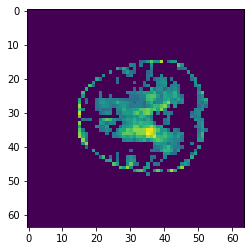

In [234]:
plt.imshow(ans[2][100, :, :])

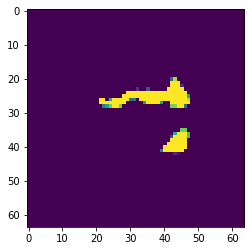

In [235]:
plt.imshow(ans[3][100, :, :])

In [69]:
import matplotlib.pyplot as plt

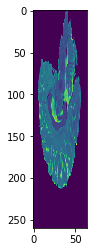

In [78]:
plt.imshow(k[0, :, 32, :])

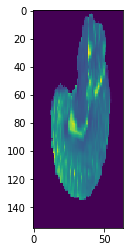

In [77]:
plt.imshow(test_brain[:, 32, :])

torch.Size([2, 260, 64, 64])

In [ ]:
config = read_conf(f'/root/cAAE/config/config_test.json')
save_path = '/root/weights'
train(config, save_path)

In [42]:
%%bash
ls /root/result/
# rm /root/result/AAE_image.png

TypeError: generator() got an unexpected keyword argument 'health_flg'